# Вопросы и ответы

Abstractive QA — это тип метода обработки естественного языка (NLP), который подразумевает генерацию ответа на заданный вопрос на естественном языке путем обобщения и синтеза информации из различных источников, а не просто выбора ответа из уже существующего текста.

В основе лежит идея поиска в больших хранилищах текстовых документов соответствующей информации, а затем использования этой информации для синтетического создания ответов.

В данной работе используется векторная база данных Pinecone.


# Установка необходимых пакетов

In [2]:
!pip install datasets pinecone-client sentence-transformers torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (73

Тут небольшая ошибка вышла, в принципе можно было установить требуемые версии пакетов, но, как оказалось эта ошибка несущественна.


# Загрузка и подготовка датасета.

Наши исходные данные будут взяты из набора данных Wiki Snippets, который содержит более 17 миллионов отрывков из Wikipedia. Но поскольку индексация всего набора данных может занять некоторое время, мы будем использовать только 50 000 отрывков в этой демонстрации, которые включают «Историю» в столбце «название раздела».

Основная проблема с которой я столкнулся изучая в том числе и отзывы на статьи о создании систем вопрос ответ связана с тем, что часто пользователи жалуются на прекращение обучения или работы с моделью в связи с ичерпанием опреративной памяти.

Чтобы избежать этих ограничений текстовые отрывки будут хранится в векторной БД Pinecone. В принципе это снимает ограничение на количество хранимых отрывков, и можно хранить намного больше, но и работать это задание будет намного дольше.

In [3]:
from datasets import load_dataset

# загрузим и перетасуем фрагменты из датасета
# я было обрадовался, что есть похожий датасет для руссеого языка,
# но это оказались отзывы покупателей
wiki_data = load_dataset(
    'vblagoje/wikipedia_snippets_streamed',
    split='train',
    streaming=True
).shuffle(seed=960)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for vblagoje/wikipedia_snippets_streamed contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/vblagoje/wikipedia_snippets_streamed.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Мы загружаем набор данных в потоковом режиме, чтобы не ждать загрузки всего набора данных (который составляет более 9 ГБ). Вместо этого мы итеративно загружаем записи по одной за раз.

In [4]:
# смотрим пример того, что мы скачали
next(iter(wiki_data))
# подходит))

{'wiki_id': 'Q7649565',
 'start_paragraph': 20,
 'start_character': 272,
 'end_paragraph': 24,
 'end_character': 380,
 'article_title': 'Sustainable Agriculture Research and Education',
 'section_title': "2000s & Evaluation of the program's effectiveness",
 'passage_text': "preserving the surrounding prairies. It ran until March 31, 2001.\nIn 2008, SARE celebrated its 20th anniversary. To that date, the program had funded 3,700 projects and was operating with an annual budget of approximately $19 million. Evaluation of the program's effectiveness As of 2008, 64% of farmers who had received SARE grants stated that they had been able to earn increased profits as a result of the funding they received and utilization of sustainable agriculture methods. Additionally, 79% of grantees said that they had experienced a significant improvement in soil quality though the environmentally friendly, sustainable methods that they were"}

In [5]:
# отфильтровываем только исторические знания
history = wiki_data.filter(
    lambda d: d['section_title'].startswith('History')
)

Давайте пройдемся по набору данных и применим наш фильтр, чтобы выбрать 50 000 исторических отрывков. Мы извлечем article_title, section_title и passage_text из каждого документа.

In [6]:
from tqdm.auto import tqdm  # прогресс-бар облегчает понимание происходящего

total_doc_count = 50000

counter = 0
docs = []
# проходим по датасету применяя фильтр
for d in tqdm(history, total=total_doc_count):
    # извлекаем нужные нам поля
    doc = {
        "article_title": d["article_title"],
        "section_title": d["section_title"],
        "passage_text": d["passage_text"]
    }
    # заполняем словарь нужными нам полями
    docs.append(doc)

    # как соберем 50 000 наборов полей - выходим
    if counter == total_doc_count:
        break

    # вполне понятная операция
    counter += 1

  0%|          | 0/50000 [00:00<?, ?it/s]

In [7]:
import pandas as pd

# создаем pandas dataframe с извлеченными нами документами
df = pd.DataFrame(docs)
df.head()

,article_title,section_title,passage_text
0,Taupo District,History,was not until the 1950s that the region starte...
1,Sutarfeni,History & Western asian analogues,Sutarfeni History strand-like pheni were Phena...
2,The Bishop Wand Church of England School,History,The Bishop Wand Church of England School Histo...
3,Teufelsmoor,History & Situation today,"made to preserve the original landscape, altho..."
4,Surface Hill Uniting Church,History,in perpetual reminder that work and worship go...


# Начинаем работу с  Pinecone Index

Индекс Pinecone хранит векторные представления наших исторических отрывков, которые мы можем получить позже с помощью другого вектора (вектора запроса). Чтобы построить наш векторный индекс, мы должны сначала установить соединение с Pinecone. Для этого нам нужен API от Pinecone. Вы можете получить его бесплатно [здесь](https://app.pinecone.io/), в принципе нужно зарегистрироваться, и действую по инструкции подключится к облачному хранилищу. Никаких проблем в процессе не возникло.

In [8]:
pip install pinecone-client

In [9]:
import os
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(api_key="960a6e0e-080e-4a01-b3a9-e84a18c1cf72")
# после регистрации пользователь получает код доступа

Далее продолжаем действовать по инструкциям с сайта, нужно уточнить провайдера и регион, выбора особого нет, оставил, как было в примерах. Заработало. [available providers and regions here](https://docs.pinecone.io/docs/projects).

In [10]:
cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'

spec = ServerlessSpec(cloud=cloud, region=region)

Нашу базу мы назовем abstractive-question-answering.

Мы указываем тип метрики как "cosine" (по умолчанию) и размерность как 768, потому что retriever, который мы используем для генерации контекстных вложений, оптимизирован для косинусного сходства и выводит 768-мерные векторы.


In [11]:
index_name = "abstractive-question-answering"

In [12]:
'''
import time
# проверяем существует ли индекс (it shouldn't if this is first time)
if index_name not in pc.list_indexes().names():
    # если не существует - создаем
    pc.create_index(
        index_name,
        dimension=768,
        metric='cosine',
        spec=spec
    )
    # ждём инициализации
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)
'''
# франгмент выше, по идее должен был создать БД прямо из блокнота,
# но у меня что-то пошло не так, и я создал эту базу прямо на сайте.
# подключаемся к базе
index = pc.Index(index_name)
# проверяем ее статус
index.describe_index_stats()

{'dimension': 768,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 50001}},
 'total_vector_count': 50001}

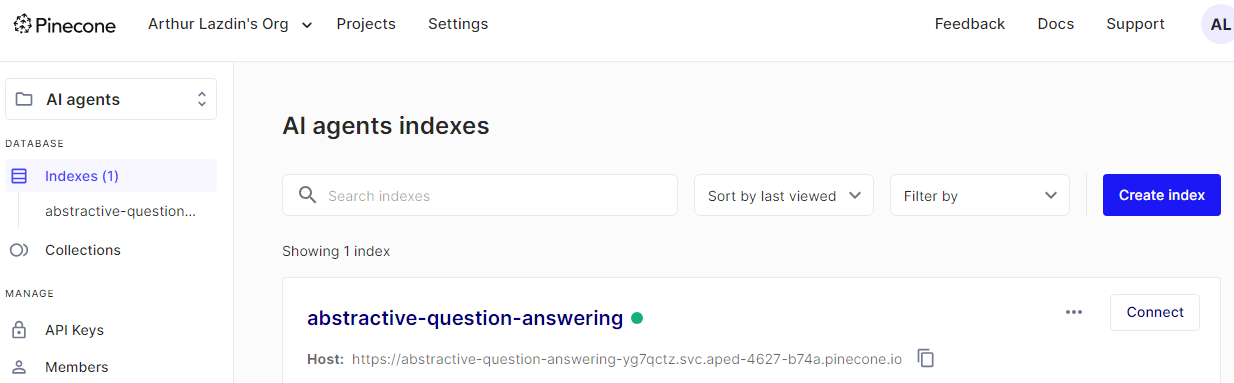

# Инициализируем Retriever

Далее нам нужно инициализировать наш ретривер. Ретривер в основном будет делать две вещи:

 - Создавать вложения для всех исторических отрывков (векторы контекста/вложения)
 - Создавать вложения для наших вопросов (вектор запроса/вложение)

Ретривер создаст вложения таким образом, чтобы вопросы и отрывки, содержащие ответы на наши запросы, были близки друг к другу в векторном пространстве. Мы будем использовать модель SentenceTransformer на основе MPNet от Microsoft в качестве нашего ретривера. Эта модель довольно хорошо справляется с сравнением сходства между запросами и документами. Мы можем использовать косинусное сходство для вычисления сходства между векторами запроса и контекста, сгенерированными этой моделью (Pinecone автоматически делает это за нас).

In [13]:
import torch
from sentence_transformers import SentenceTransformer

# set device to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# load the retriever model from huggingface model hub
retriever = SentenceTransformer("flax-sentence-embeddings/all_datasets_v3_mpnet-base", device=device)
retriever

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.85k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/591 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

# Генерация Embeddings and Upsert (решил оставить англоязычные термины)


Далее нам нужно сгенерировать вложения для контекстных отрывков. Мы сделаем это партиями, чтобы ускорить генерацию вложений и загрузку их в индекс Pinecone. При передаче документов в Pinecone нам нужен идентификатор (уникальное значение), контекстное вложение и метаданные для каждого документа, представляющего контекстные отрывки в наборе данных. Метаданные — это словарь, содержащий данные, относящиеся к нашим вложениям, такие как заголовок статьи, заголовок раздела, текст отрывка и пр.

In [14]:
# размер партии или батча, или batche (я запутался) будет 64
batch_size = 64

for i in tqdm(range(0, len(df), batch_size)):
    # ищем конец батча
    i_end = min(i+batch_size, len(df))
    # извлекаем его
    batch = df.iloc[i:i_end]
    # генерируем для него embeddings
    emb = retriever.encode(batch["passage_text"].tolist()).tolist()
    # плучаем метаданные
    meta = batch.to_dict(orient="records")
    # создаем уникальный ID
    ids = [f"{idx}" for idx in range(i, i_end)]
    # добавляем все в upsert list
    to_upsert = list(zip(ids, emb, meta))
    # upsert/insert помещаем запись в pinecone
    _ = index.upsert(vectors=to_upsert)

# смотрим что получилось
index.describe_index_stats()

  0%|          | 0/782 [00:00<?, ?it/s]

{'dimension': 768,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 50001}},
 'total_vector_count': 50001}

 # Инициализируем генератор

Мы будем использовать ELI5 BART для генератора, который представляет собой модель Sequence-To-Sequence, обученную с использованием набора данных «Explain Like I’m 5» (ELI5). Модели Sequence-To-Sequence могут принимать текстовую последовательность в качестве входных данных и выдавать другую текстовую последовательность в качестве выходных данных.

Входные данные для модели ELI5 BART — это одна строка, которая является конкатенацией запроса и соответствующих документов, предоставляющих контекст для ответа. Документы разделены специальным токеном  &lt;P>, поэтому входная строка будет выглядеть следующим образом:


>question: What is a sonic boom? context: &lt;P> A sonic boom is a sound associated with shock waves created when an object travels through the air faster than the speed of sound. &lt;P> Sonic booms generate enormous amounts of sound energy, sounding similar to an explosion or a thunderclap to the human ear. &lt;P> Sonic booms due to large supersonic aircraft can be particularly loud and startling, tend to awaken people, and may cause minor damage to some structures. This led to prohibition of routine supersonic flight overland.

More detail on how the ELI5 dataset was built is available [here](https://arxiv.org/abs/1907.09190) and how ELI5 BART model was trained is available [here](https://yjernite.github.io/lfqa.html).

Вперёд!

In [15]:
from transformers import BartTokenizer, BartForConditionalGeneration

# load bart tokenizer and model from huggingface
tokenizer = BartTokenizer.from_pretrained('vblagoje/bart_lfqa')
generator = BartForConditionalGeneration.from_pretrained('vblagoje/bart_lfqa').to(device)

tokenizer_config.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

В принципе всё готово.
Определим вспомогательные функции для извлечения контекстных отрывков из индекса Pinecone и форматирования запроса таким образом, как генератор ожидает входные данные.

In [16]:
def query_pinecone(query, top_k):
    # генерируем вложение для запроса
    xq = retriever.encode([query]).tolist()
    # собственно поиск
    xc = index.query(vector=xq, top_k=top_k, include_metadata=True)
    return xc

In [17]:
def format_query(query, context):
    # извлекаем поле  passage_text из  Pinecone
    context = [f"<P> {m['metadata']['passage_text']}" for m in context]
    # объединяем найденное
    context = " ".join(context)
    # готовим результат
    query = f"question: {query} context: {context}"
    return query

Протестируем работу вспомогательных функций.

Мы выполним запрос к функции индекса Pinecone, которую мы создали ранее, с помощью `query_pinecone`, чтобы получить контекстные фрагменты и передать их функции `format_query`.


In [18]:
query = "when was the first electric power system built?"
result = query_pinecone(query, top_k=1)
result

{'matches': [{'id': '3593',
              'metadata': {'article_title': 'Electric power system',
                           'passage_text': 'Electric power system History In '
                                           '1881, two electricians built the '
                                           "world's first power system at "
                                           'Godalming in England. It was '
                                           'powered by two waterwheels and '
                                           'produced an alternating current '
                                           'that in turn supplied seven '
                                           'Siemens arc lamps at 250 volts and '
                                           '34 incandescent lamps at 40 volts. '
                                           'However, supply to the lamps was '
                                           'intermittent and in 1882 Thomas '
                                           'Ed

In [19]:
from pprint import pprint

In [20]:
# Отформатируем запрос
query = format_query(query, result["matches"])
pprint(query)

('question: when was the first electric power system built? context: <P> '
 "Electric power system History In 1881, two electricians built the world's "
 'first power system at Godalming in England. It was powered by two '
 'waterwheels and produced an alternating current that in turn supplied seven '
 'Siemens arc lamps at 250 volts and 34 incandescent lamps at 40 volts. '
 'However, supply to the lamps was intermittent and in 1882 Thomas Edison and '
 'his company, The Edison Electric Light Company, developed the first '
 'steam-powered electric power station on Pearl Street in New York City. The '
 'Pearl Street Station initially powered around 3,000 lamps for 59 customers. '
 'The power station generated direct current and')


Вывод выглядит лучше. Теперь давайте напишем функцию для генерации ответов.


In [21]:
def generate_answer(query):
    # токенизируем запрос для получения input_ids
    inputs = tokenizer([query], max_length=1024, return_tensors="pt").to(device)
    # использовать генератор для прогнозирования выходных идентификаторов
    ids = generator.generate(inputs["input_ids"], num_beams=2, min_length=20, max_length=40)
    # декодируем
    answer = tokenizer.batch_decode(ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    return pprint(answer)

In [22]:
generate_answer(query)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


('The first electric power system was built in 1881 at Godalming in England. '
 'It was powered by two waterwheels and produced alternating current that in '
 'turn supplied seven Siemens arc lamps')


Генератор использовал предоставленный контекст для ответа на наш вопрос. Теперь можно поиграть в игру "Спроси у Wiki".


In [23]:
query = "How was the first wireless message sent?"
context = query_pinecone(query, top_k=5)
query = format_query(query, context["matches"])
generate_answer(query)

('The first wireless message was sent in 1866 by Mahlon Loomis, who had a kite '
 'on a mountaintop 14 miles apart. The kite was connected to a cable')


Чтобы подтвердить правильность этого ответа, мы можем проверить контексты, использованные для генерации ответа.

In [24]:
for doc in context["matches"]:
    print(doc["metadata"]["passage_text"], end='\n---\n')

by electrostatic induction or electromagnetic induction, which had too short a range to be practical. In 1866 Mahlon Loomis claimed to have transmitted an electrical signal through the atmosphere between two 600 foot wires held aloft by kites on mountaintops 14 miles apart. Thomas Edison had come close to discovering radio in 1875; he had generated and detected radio waves which he called "etheric currents" experimenting with high-voltage spark circuits, but due to lack of time did not pursue the matter. David Edward Hughes in 1879 had also stumbled on radio wave transmission which he received with his carbon microphone
---
the east coast of India, then on to Penang, Malacca, Singapore, Batavia (current Jakarta), to finally reach Darwin, Australia. It was the first direct link between Australia and Great Britain. The company that laid the first part of the cable took the name of Falmouth, Gibraltar and Malta Telegraph Company and had been founded in 1869. This company later operated as

В этом случае ответ выглядит правильным. Если мы зададим вопрос и не получим релевантных контекстов, генератор обычно будет возвращать бессмысленные или ложные ответы, как в случае с этим вопросом о первом человеке на Марсе:

In [25]:
query = "who was the first person on the mars?"
context = query_pinecone(query, top_k=3)
query = format_query(query, context["matches"])
generate_answer(query)

('The first person to go to Mars was probably the first person to walk on the '
 'surface of the planet. The first person to walk on the surface of the planet '
 'was probably the first person to')


Вот тот случай, когда генератор начинает "выкручиваться".
Потому что на Марсе людей не было.

In [26]:
for doc in context["matches"]:
    print(doc["metadata"]["passage_text"], end='\n---\n')

in organic form would be liberated as carbon dioxide again through combustion, "short-circuiting" the terraforming process.
Sagan also visualized making Mars habitable for human life in "Planetary Engineering on Mars" (1973), an article published in the journal Icarus. Three years later, NASA addressed the issue of planetary engineering officially in a study, but used the term "planetary ecosynthesis" instead. The study concluded that it was possible for Mars to support life and be made into a habitable planet. The first conference session on terraforming, then referred to as "Planetary Modeling", was organized that same year.
In March 1979, NASA engineer and author
---
indicated in November 2018 that "We've recently made a number of breakthroughs [that I am] just really fired up about." and that, as a result, he foresees a 70 percent probability that he personally would go to Mars.  He answered an interviewer's question that included a presumption that "a Mars voyage could be an escap

Можно ещё поспрашивать.

In [27]:
query = "who was the first person on the moon?"
context = query_pinecone(query, top_k=10)
query = format_query(query, context["matches"])
generate_answer(query)

('The first person to walk on the moon was Neil Armstrong in 1969. He walked '
 'on the moon in 1969. He was the first person to walk on the moon.')


А на Луне люди были!

In [28]:
query = "Which side is the heart located on?"
context = query_pinecone(query, top_k=3)
query = format_query(query, context["matches"])
generate_answer(query)

('The heart is located on the left side of the body. The left side of the body '
 'is called the ventricle. The right side of the body is called the ventricle.')


Ответ удивил, потому что правильный, но тематика - историческая. Но может была история про анатомию.

In [32]:
query = "what country is london the capital of?"
context = query_pinecone(query, top_k=3)
query = format_query(query, context["matches"])
generate_answer(query)

('London is the capital of the UK. It is also the capital of the United '
 'Kingdom of Great Britain and Northern Ireland.')


С исторической географией тоже всё в порядке!